In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
from collections import Counter

# Machine learning imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

In [20]:
# Text preprocessing imports
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
df = pd.read_csv('sms_dataset.csv')

print("Dataset Shape:", df.shape)
print("\nColumn Names:", df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check label distribution
print("\nLabel Distribution:")
print(df['LABEL'].value_counts())
print("\nLabel Distribution (%):")
print(df['LABEL'].value_counts(normalize=True) * 100)


Dataset Shape: (5971, 5)

Column Names: ['LABEL', 'TEXT', 'URL', 'EMAIL', 'PHONE']

First 5 rows:
      LABEL                                               TEXT URL EMAIL PHONE
0       ham  Your opinion about me? 1. Over 2. Jada 3. Kusr...  No    No    No
1       ham  What's up? Do you want me to come online? If y...  No    No    No
2       ham                       So u workin overtime nigpun?  No    No    No
3       ham  Also sir, i sent you an email about how to log...  No    No    No
4  Smishing  Please Stay At Home. To encourage the notion o...  No    No    No

Missing Values:
LABEL    0
TEXT     0
URL      0
EMAIL    0
PHONE    0
dtype: int64

Label Distribution:
LABEL
ham         4844
Smishing     616
spam         466
Spam          23
smishing      22
Name: count, dtype: int64

Label Distribution (%):
LABEL
ham         81.125440
Smishing    10.316530
spam         7.804388
Spam         0.385195
smishing     0.368447
Name: proportion, dtype: float64


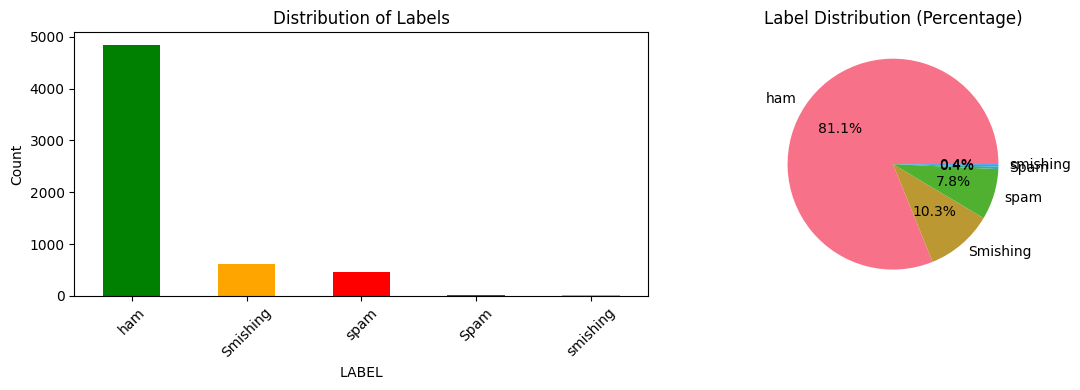

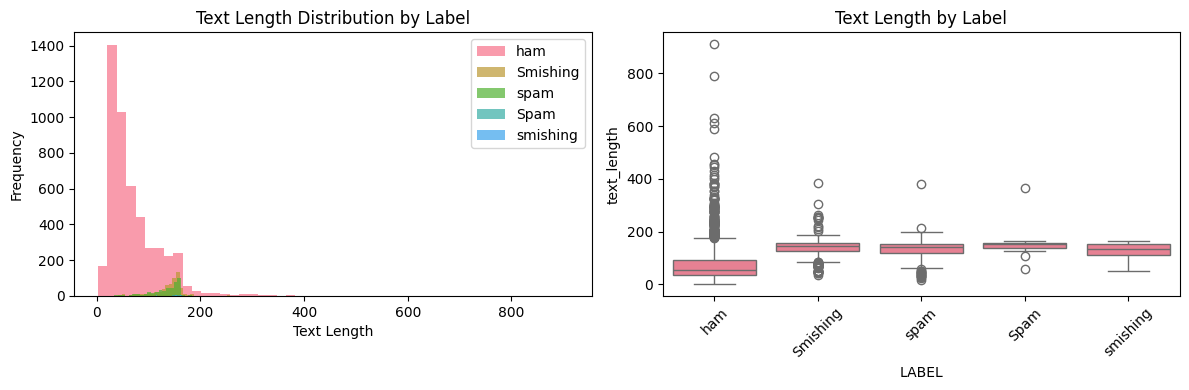

In [16]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
df['LABEL'].value_counts().plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Distribution of Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
df['LABEL'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Label Distribution (Percentage)')
plt.ylabel('')

plt.tight_layout()
plt.show()

# Text length analysis
df['text_length'] = df['TEXT'].str.len()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
for label in df['LABEL'].unique():
    data = df[df['LABEL'] == label]['text_length']
    plt.hist(data, alpha=0.7, label=label, bins=50)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Text Length Distribution by Label')
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='LABEL', y='text_length')
plt.title('Text Length by Label')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [21]:
def preprocess_text(text):
    """
    Comprehensive text preprocessing function
    """
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove phone numbers (various formats)
    text = re.sub(r'[\+]?[1-9]?[0-9]{7,15}', '', text)
    text = re.sub(r'\(?[0-9]{3}\)?[-.\s]?[0-9]{3}[-.\s]?[0-9]{4}', '', text)

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

def advanced_preprocess(text):
    """
    Advanced preprocessing with stopword removal using regex tokenization
    """
    text = preprocess_text(text)

    # Tokenize using regex and remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = re.findall(r'\b\w+\b', text) # Use regex for tokenization
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]

    return ' '.join(tokens)

# Apply preprocessing
print("Applying text preprocessing...")
df['text_clean'] = df['TEXT'].apply(preprocess_text)
df['text_advanced'] = df['TEXT'].apply(advanced_preprocess)

# Show examples of preprocessing
print("\nPreprocessing Examples:")
for i in range(3):
    print(f"\nOriginal: {df.iloc[i]['TEXT'][:100]}...")
    print(f"Clean: {df.iloc[i]['text_clean'][:100]}...")
    print(f"Advanced: {df.iloc[i]['text_advanced'][:100]}...")

Applying text preprocessing...

Preprocessing Examples:

Original: Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl character 7. Not matu...
Clean: your opinion about me over jada kusruthi lovable silent spl character not matured stylish simple pls...
Advanced: opinion jada kusruthi lovable silent spl character matured stylish simple pls reply...

Original: What's up? Do you want me to come online? If you are free we can talk sometime�...
Clean: whats up do you want me to come online if you are free we can talk sometime...
Advanced: whats want come online free talk sometime...

Original: So u workin overtime nigpun?...
Clean: so u workin overtime nigpun...
Advanced: workin overtime nigpun...


In [22]:
def extract_features(df):
    """
    Extract additional features from the text
    """
    features = pd.DataFrame()

    # Text statistics
    features['char_count'] = df['TEXT'].str.len()
    features['word_count'] = df['TEXT'].str.split().str.len()
    features['sentence_count'] = df['TEXT'].str.count(r'[.!?]+')
    features['avg_word_length'] = features['char_count'] / features['word_count']

    # Special characters
    features['exclamation_count'] = df['TEXT'].str.count('!')
    features['question_count'] = df['TEXT'].str.count('\\?')
    features['dollar_count'] = df['TEXT'].str.count('\\$')
    features['percent_count'] = df['TEXT'].str.count('%')

    # Capital letters
    features['capital_ratio'] = df['TEXT'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)

    # URLs, emails, phones (binary features)
    features['has_url'] = df['TEXT'].str.contains(r'http[s]?://').astype(int)
    features['has_email'] = df['TEXT'].str.contains(r'\S+@\S+').astype(int)
    features['has_phone'] = df['TEXT'].str.contains(r'\d{3}[-.]?\d{3}[-.]?\d{4}').astype(int)

    return features

# Extract features
print("Extracting additional features...")
feature_df = extract_features(df)
print(f"Extracted {feature_df.shape[1]} additional features")



Extracting additional features...
Extracted 12 additional features


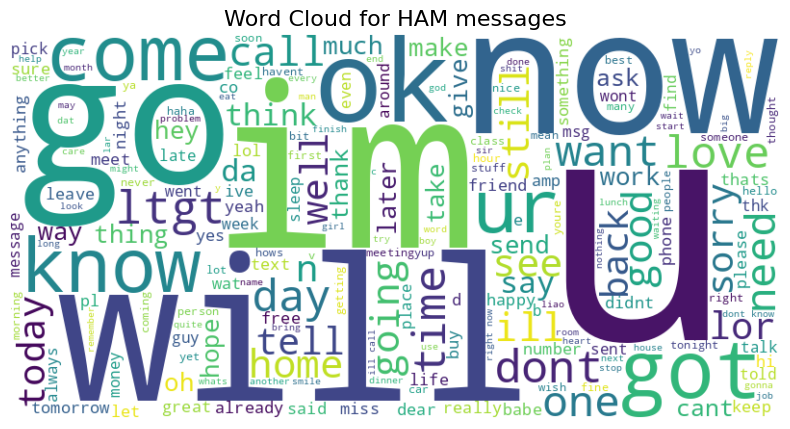

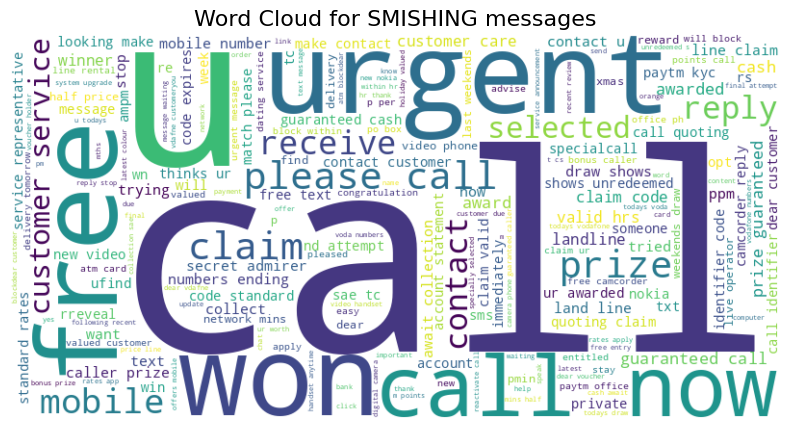

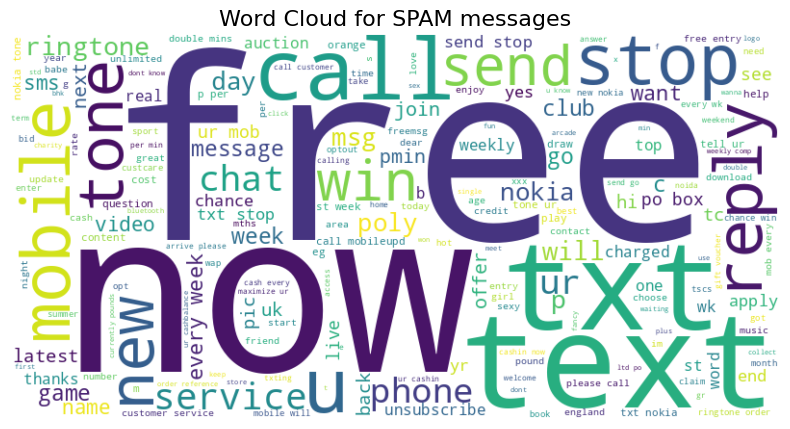

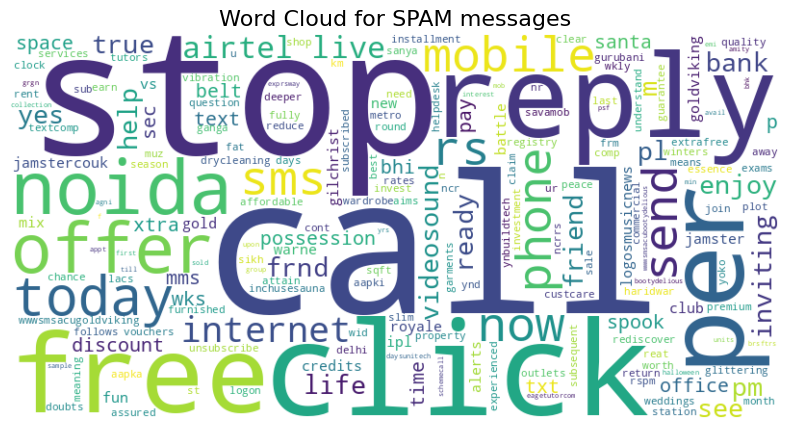

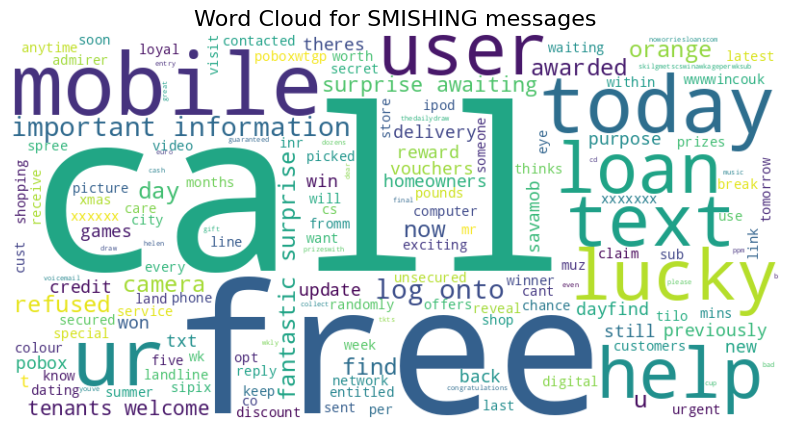

In [23]:

def create_wordcloud(text_series, title):
    """Create and display word cloud"""
    text = ' '.join(text_series.dropna())
    if len(text) > 0:
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(title, size=16)
        plt.axis('off')
        plt.show()

# Create word clouds for each label
for label in df['LABEL'].unique():
    label_text = df[df['LABEL'] == label]['text_clean']
    create_wordcloud(label_text, f'Word Cloud for {label.upper()} messages')


In [24]:
X_text = df['text_advanced']
X_features = feature_df
y = df['LABEL']

# Split the data
X_text_train, X_text_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    X_text, X_features, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_text_train)}")
print(f"Test set size: {len(X_text_test)}")
print(f"Training label distribution:\n{y_train.value_counts()}")

Training set size: 4776
Test set size: 1195
Training label distribution:
LABEL
ham         3874
Smishing     493
spam         373
smishing      18
Spam          18
Name: count, dtype: int64


In [25]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train and evaluate a model
    """
    print(f"\n{'='*50}")
    print(f"Training {model_name}")
    print(f"{'='*50}")

    # Train the model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"\nCross-validation scores: {cv_scores}")
    print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    return model, accuracy

Training models with text features only...

Training Naive Bayes + TF-IDF
Accuracy: 0.9230

Classification Report:
              precision    recall  f1-score   support

    Smishing       0.90      0.80      0.84       123
        Spam       0.00      0.00      0.00         5
         ham       0.93      1.00      0.96       970
    smishing       0.00      0.00      0.00         4
        spam       0.82      0.40      0.54        93

    accuracy                           0.92      1195
   macro avg       0.53      0.44      0.47      1195
weighted avg       0.91      0.92      0.91      1195



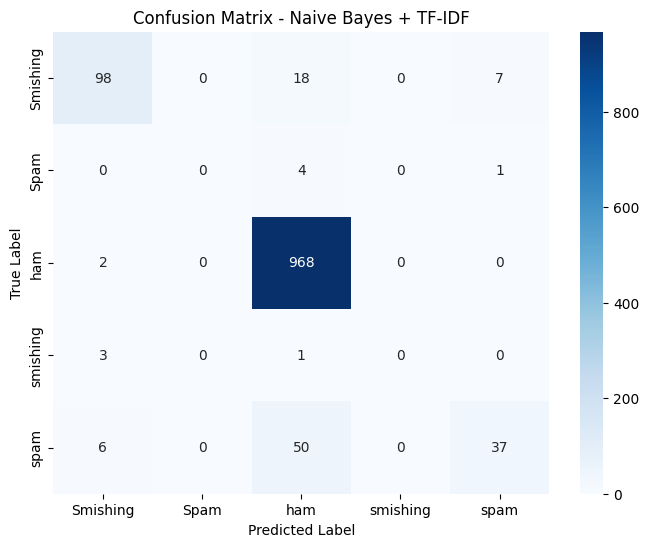


Cross-validation scores: [0.91631799 0.92460733 0.90366492 0.92984293 0.91832461]
Mean CV accuracy: 0.9186 (+/- 0.0177)

Training Logistic Regression + TF-IDF
Accuracy: 0.9322

Classification Report:
              precision    recall  f1-score   support

    Smishing       0.93      0.81      0.87       123
        Spam       0.00      0.00      0.00         5
         ham       0.94      1.00      0.97       970
    smishing       0.00      0.00      0.00         4
        spam       0.81      0.51      0.62        93

    accuracy                           0.93      1195
   macro avg       0.54      0.46      0.49      1195
weighted avg       0.92      0.93      0.92      1195



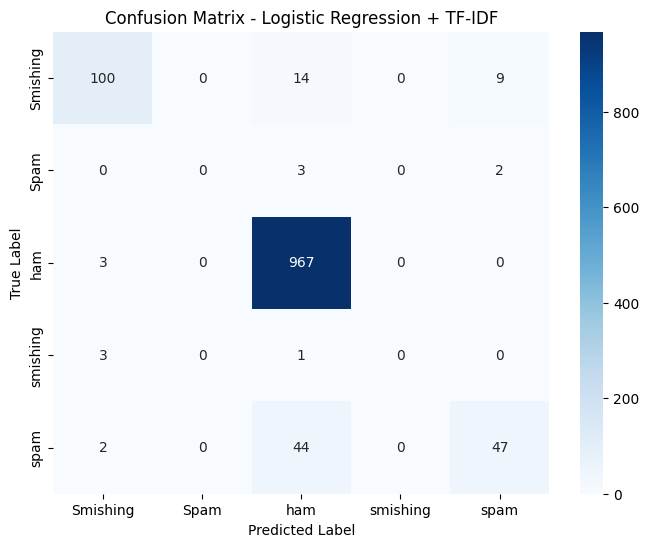


Cross-validation scores: [0.92991632 0.92879581 0.91308901 0.93298429 0.91518325]
Mean CV accuracy: 0.9240 (+/- 0.0164)

Training SVM + TF-IDF
Accuracy: 0.9397

Classification Report:
              precision    recall  f1-score   support

    Smishing       0.86      0.83      0.85       123
        Spam       0.00      0.00      0.00         5
         ham       0.96      0.99      0.98       970
    smishing       0.00      0.00      0.00         4
        spam       0.78      0.65      0.71        93

    accuracy                           0.94      1195
   macro avg       0.52      0.49      0.51      1195
weighted avg       0.93      0.94      0.93      1195



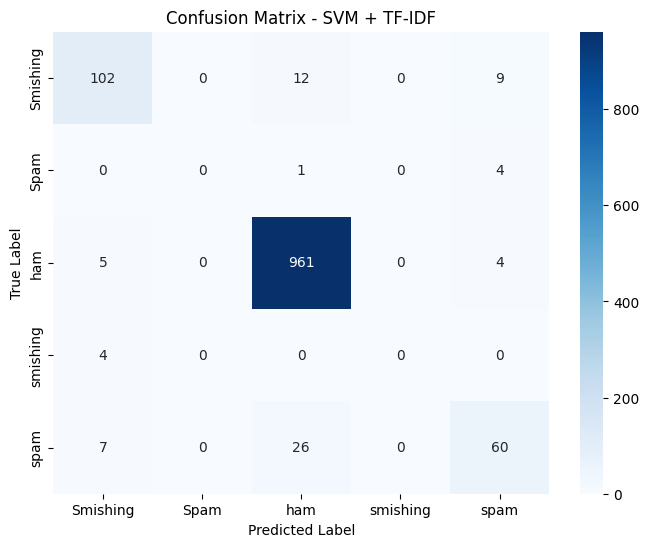


Cross-validation scores: [0.94246862 0.9382199  0.93403141 0.94240838 0.9434555 ]
Mean CV accuracy: 0.9401 (+/- 0.0071)

Training Random Forest + Count Vectorizer
Accuracy: 0.9372

Classification Report:
              precision    recall  f1-score   support

    Smishing       0.89      0.80      0.84       123
        Spam       0.00      0.00      0.00         5
         ham       0.96      0.99      0.98       970
    smishing       0.00      0.00      0.00         4
        spam       0.75      0.67      0.70        93

    accuracy                           0.94      1195
   macro avg       0.52      0.49      0.50      1195
weighted avg       0.93      0.94      0.93      1195



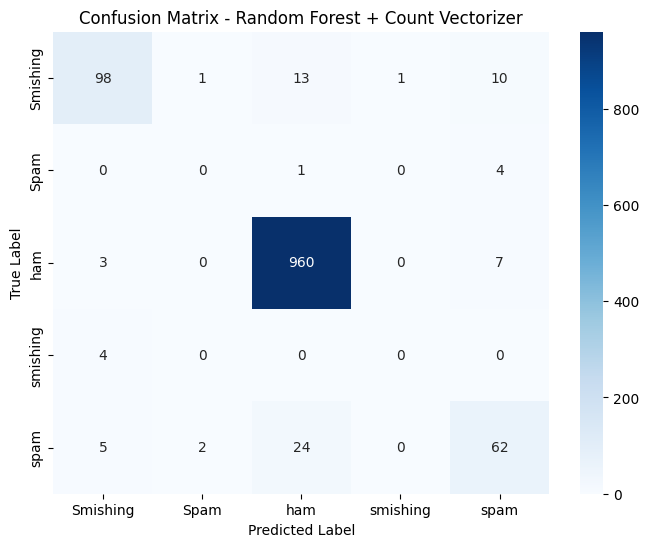


Cross-validation scores: [0.92364017 0.92984293 0.93193717 0.93403141 0.93298429]
Mean CV accuracy: 0.9305 (+/- 0.0074)


In [26]:
models_results = {}

# 1. Naive Bayes with TF-IDF
print("Training models with text features only...")

nb_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))),
    ('nb', MultinomialNB())
])

model, acc = evaluate_model(nb_tfidf, X_text_train, X_text_test, y_train, y_test, "Naive Bayes + TF-IDF")
models_results["NB + TF-IDF"] = acc

# 2. Logistic Regression with TF-IDF
lr_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))),
    ('lr', LogisticRegression(random_state=42, max_iter=1000))
])

model, acc = evaluate_model(lr_tfidf, X_text_train, X_text_test, y_train, y_test, "Logistic Regression + TF-IDF")
models_results["LR + TF-IDF"] = acc

# 3. SVM with TF-IDF
svm_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, stop_words='english', ngram_range=(1, 2))),
    ('svm', SVC(kernel='linear', random_state=42))
])

model, acc = evaluate_model(svm_tfidf, X_text_train, X_text_test, y_train, y_test, "SVM + TF-IDF")
models_results["SVM + TF-IDF"] = acc

# 4. Random Forest with Count Vectorizer
rf_count = Pipeline([
    ('count', CountVectorizer(max_features=3000, stop_words='english', ngram_range=(1, 2))),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])

model, acc = evaluate_model(rf_count, X_text_train, X_text_test, y_train, y_test, "Random Forest + Count Vectorizer")
models_results["RF + Count"] = acc


In [27]:
print("\n" + "="*60)
print("HYPERPARAMETER TUNING")
print("="*60)

# Find the best performing model
best_model_name = max(models_results, key=models_results.get)
print(f"Best performing model: {best_model_name} with accuracy: {models_results[best_model_name]:.4f}")

# Hyperparameter tuning for Logistic Regression (usually performs well)
print("\nPerforming hyperparameter tuning for Logistic Regression...")

param_grid = {
    'tfidf__max_features': [3000, 5000, 10000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'lr__C': [0.1, 1, 10, 100]
}

grid_search = GridSearchCV(
    Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english')),
        ('lr', LogisticRegression(random_state=42, max_iter=1000))
    ]),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_text_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_text_test)
best_accuracy = accuracy_score(y_test, y_pred_best)

print(f"Best model test accuracy: {best_accuracy:.4f}")
print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred_best))



HYPERPARAMETER TUNING
Best performing model: SVM + TF-IDF with accuracy: 0.9397

Performing hyperparameter tuning for Logistic Regression...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'lr__C': 10, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 3)}
Best cross-validation score: 0.9403
Best model test accuracy: 0.9439

Final Classification Report:
              precision    recall  f1-score   support

    Smishing       0.89      0.83      0.86       123
        Spam       0.00      0.00      0.00         5
         ham       0.96      0.99      0.98       970
    smishing       0.00      0.00      0.00         4
        spam       0.82      0.67      0.73        93

    accuracy                           0.94      1195
   macro avg       0.53      0.50      0.51      1195
weighted avg       0.94      0.94      0.94      1195



In [28]:
def predict_message(text, model=best_model):
    """
    Predict the label for a new message
    """
    # Preprocess the text
    clean_text = advanced_preprocess(text)

    # Make prediction
    prediction = model.predict([clean_text])[0]
    probability = model.predict_proba([clean_text])[0]

    # Get class probabilities
    classes = model.classes_
    prob_dict = dict(zip(classes, probability))

    print(f"Input text: {text}")
    print(f"Prediction: {prediction}")
    print("Probabilities:")
    for class_name, prob in prob_dict.items():
        print(f"  {class_name}: {prob:.4f}")

    return prediction, prob_dict


In [29]:
print("\n" + "="*60)
print("TESTING WITH SAMPLE MESSAGES")
print("="*60)

# Test messages
test_messages = [
    "Congratulations! You've won $1000! Click here to claim your prize now!",
    "Hey, are you free for lunch tomorrow?",
    "URGENT: Your account will be suspended. Verify your details at fake-bank-link.com",
    "Meeting scheduled for 3 PM in conference room B",
    "Free iPhone! Text STOP to unsubscribe. Limited time offer!"
]

for i, message in enumerate(test_messages, 1):
    print(f"\n--- Test Message {i} ---")
    predict_message(message)



TESTING WITH SAMPLE MESSAGES

--- Test Message 1 ---
Input text: Congratulations! You've won $1000! Click here to claim your prize now!
Prediction: Smishing
Probabilities:
  Smishing: 0.9951
  Spam: 0.0015
  ham: 0.0022
  smishing: 0.0003
  spam: 0.0008

--- Test Message 2 ---
Input text: Hey, are you free for lunch tomorrow?
Prediction: ham
Probabilities:
  Smishing: 0.0038
  Spam: 0.0004
  ham: 0.9921
  smishing: 0.0005
  spam: 0.0032

--- Test Message 3 ---
Input text: URGENT: Your account will be suspended. Verify your details at fake-bank-link.com
Prediction: Smishing
Probabilities:
  Smishing: 0.7926
  Spam: 0.0025
  ham: 0.1711
  smishing: 0.0028
  spam: 0.0310

--- Test Message 4 ---
Input text: Meeting scheduled for 3 PM in conference room B
Prediction: ham
Probabilities:
  Smishing: 0.0026
  Spam: 0.0003
  ham: 0.9942
  smishing: 0.0003
  spam: 0.0025

--- Test Message 5 ---
Input text: Free iPhone! Text STOP to unsubscribe. Limited time offer!
Prediction: spam
Probabilities

In [30]:
print("\n" + "="*60)
print("SAVING THE MODEL")
print("="*60)

import joblib

# Save the best model
joblib.dump(best_model, 'spam_detection_model.pkl')



SAVING THE MODEL


['spam_detection_model.pkl']